In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Read the dataset
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

Using TensorFlow backend.


x_train shape: (60000, 28, 28) y_train shape: (60000,)


60000 train set
10000 test set
y = 2 Pullover


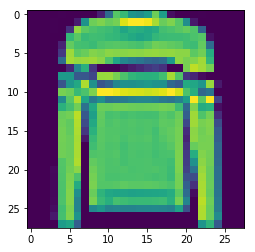

In [4]:
# Print the number of training and test datasets
print(x_train.shape[0], 'train set')
print(x_test.shape[0], 'test set')

# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

# Image index, you can pick any number between 0 and 59,999
img_index = 5

# y_train contains the lables, ranging from 0 to 9
label_index = y_train[img_index]

# Print the label, for example 2 Pullover
print ("y = " + str(label_index) + " " +(fashion_mnist_labels[label_index]))

# Show one of the images from the training dataset
plt.imshow(x_train[img_index])

In [5]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        filter1 = tf.get_variable('d_f1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias1   = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        output1 = tf.nn.conv2d(input=images, filter=filter1, strides=[1, 1, 1, 1], padding='SAME')
        output1 = output1 + bias1
        output1 = tf.nn.relu(output1)
        output1 = tf.nn.avg_pool(output1, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding='SAME')
        
        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        filter2 = tf.get_variable('d_f2', [5,5,32,64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias2   = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        output2 = tf.nn.conv2d(input=output1, filter=filter2, strides=[1,1,1,1], padding='SAME')
        output2 = output2 + bias2
        output2 = tf.nn.relu(output2)
        output2 = tf.nn.avg_pool(output2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        # First fully connected layer
        weight3 = tf.get_variable('d_w3', [7*7*64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias3   = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        output3 = tf.reshape(output2, [-1, 7*7*64])
        output3 = tf.matmul(output3, weight3) + bias3
        output3 = tf.nn.relu(output3)
        
        # Second fully connected layer
        weight4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias4   = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        output4 = tf.matmul(output3, weight4) + bias4
        
        # output4 contains unscaled values
        return output4

In [6]:
def generator(z, batch_size, z_dim):
    # From z_dim to 56*56 dimension
    weight1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    bias1   = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    output1 = tf.matmul(z, weight1) + bias1
    output1 = tf.reshape(output1, [-1, 56, 56, 1])
    output1 = tf.contrib.layers.batch_norm(output1, epsilon=1e-5, scope='bn1')
    output1 = tf.nn.relu(output1)
    
    # Generate 50 features
    weight2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    bias2   = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    output2 = tf.nn.conv2d(output1, weight2, strides=[1,2,2,1], padding='SAME')
    output2 = output2 + bias2
    output2 = tf.contrib.layers.batch_norm(output2, epsilon=1e-5, scope='bn2')
    output2 = tf.nn.relu(output2)
    output2 = tf.image.resize_images(output2, [56,56])

    # Generate 25 features
    weight3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    bias3   = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    output3 = tf.nn.conv2d(output2, weight3, strides=[1,2,2,1], padding='SAME')
    output3 = output3 + bias3
    output3 = tf.contrib.layers.batch_norm(output3, epsilon=1e-5, scope='bn3')
    output3 = tf.nn.relu(output3)
    output3 = tf.image.resize_images(output3, [56, 56])
    
    # Final convolution with one output channel
    weight4 = tf.get_variable('g_w4', [1,1,z_dim/4,1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    bias4   = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    output4 = tf.nn.conv2d(output3, weight4, strides=[1,2,2,1], padding='SAME')
    output4 = output4 + bias4
    output4 = tf.sigmoid(output4)
    
    # Dimension of output4: batch_size x 28 x 28 x 2
    return output4

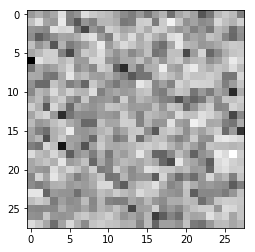

In [7]:
""" See the fake image we make """

# Define the plaaceholder and the graph
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

# For generator, one image for a batch
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output, feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')
#     plt.savefig('/img/test_img.png')

In [30]:
tf.reset_default_graph()

In [31]:
batch_size = 128 # should be 2^n

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1], name='x_placeholder')
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions)
# Gz holds the generated images

Dx = discriminator(x_placeholder)
# Dx will hold discriminator prediction probabilities for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

In [32]:
# Two Loss Functions for discirminator
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

# Loss function for generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [33]:
# Get the variables for different network
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

# Train the discirminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [34]:
# """ For setting TensorBoard """

# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

In [35]:
""" Start Training Session """

saver = tf.train.Saver()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(500):
    
    for j in range(1500//batch_size):
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        # real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    
        real_image_batch = x_train[j*batch_size:(j+1)*batch_size].reshape([batch_size, 28, 28, 1])
        _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                               {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

dLossReal: 0.0993647 dLossFake: 0.6836779
dLossReal: 0.0 dLossFake: 9.750632e-06
dLossReal: 6.95669e-35 dLossFake: 4.399728e-06
dLossReal: 3.8271688e-17 dLossFake: 3.361105e-06
dLossReal: 5.7649045e-15 dLossFake: 2.5053541e-06


In [36]:
# Train generator and discriminator together
for i in range(300):
    for j in range(60000//batch_size):
        real_image_batch = x_train[j*batch_size:(j+1)*batch_size].reshape([batch_size, 28, 28, 1])
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

        # Train discriminator on both real and fake images
        _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                               {x_placeholder: real_image_batch, z_placeholder: z_batch})

        # Train generator
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

dLossReal: 0.026286315 dLossFake: 0.014274681


KeyboardInterrupt: 

In [27]:
z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
_ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})
print(_)

None


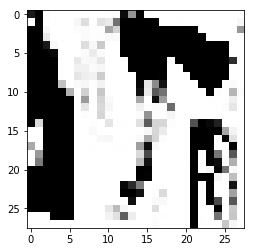

In [37]:
z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
generated_image = sess.run(Gz, feed_dict={z_placeholder: z_batch})
generated_image = generated_image.reshape([batch_size, 28, 28])
plt.imshow(generated_image[0], cmap='Greys')